<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h5><i><center>Sncf delay prediction project</center></i></h5>

<h1>
<hr style=" border:none; height:3px;">
<center>DELAY CAUSES CLASSIFICATION</center>
<hr style=" border:none; height:3px;">
</h1>


In [196]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Numpy arrays are used to store training and test data.
import numpy as np

# Pandas is used to manipulate tabular data.
import pandas as pd
pd.set_option('display.max_columns', None)

# Seaborn is used to make nice plot 
import seaborn as sns

# Matplotlib is used to plot graphs.
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# Style options for plots.
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 0. Introduction

Ici nous allons traiter un nouveau `Use Case` du projet sur le retard SNCF. Nous avons réussi pour le moment à obtenir un prédiciton du nombre de train en retard pour les mois futurs. Maintenant le but en tant qu'agent de la SNCF serait d'empêcher ces retards. Pour cela, nous pouvons lui fournir un répartition probabiliste de la causes des retard parmis les catégories suivantes : 
+ Retards dus <strong>Externes</strong> -> (<i>Difficilement évitables</i>).
+ Retards liés aux <strong>infrastructures</strong> -> (<i>Possibilité de faire réviser le matériel</i>).
+ Retards liés à la <strong>gestion du traffic</strong> -> (<i>Augmentation de la vigilances pour les opérateurs du traffic</i>).
+ Retards liés au <strong>matériel roulant et son état</strong> -> (<i>Possibilité de faire réviser le matériel</i>).
+ Retards liés à la <strong>gestion de gare</strong> -> (<i>Possibilité d'augmenter ou non les nombres d'agents en gare</i>).
+ Retards liées à la <strong>prise en charge de voyageurs</strong> -> (<i>Difficilement évitables</i>).

Afin de réaliser cette tâche nous allons procédé étape par étape dans notre démarche, en utilisant les différents outils vu dans le cours, afin d'obtenir le meilleur predicteur par rapport à la `RMSE`.

# 1. Exploratory Data Analysis

In [197]:
## Import our main dataset
data_path = "../dataset/regularite-mensuelle-tgv-aqst.csv" 
df_base = pd.read_csv(data_path, sep=",")
df_base.head()

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,commentaire_retards_depart,nb_train_retard_arrivee,retard_moyen_arrivee,retard_moyen_tous_trains_arrivee,commentaires_retard_arrivee,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,NaN,289,11.247809,3.693179,NaN,147,28.436735,6.511118,NaN,110,6.511118,44,8,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,NaN,8,2.875000,0.095796,NaN,34,21.524020,5.696096,NaN,22,5.696096,5,0,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,NaN,37,9.501351,1.003981,NaN,26,55.692308,7.578947,"Ce mois-ci, l'OD a été touchée par les inciden...",26,7.548387,17,7,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,2018-01,National,PARIS MONTPARNASSE,ST MALO,156,102,0,NaN,12,19.912500,1.966667,NaN,13,48.623077,6.790686,"Ce mois-ci, l'OD a été touchée par les inciden...",8,6.724757,6,4,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,NaN,61,7.796995,0.886889,NaN,71,12.405164,3.346487,NaN,17,3.346487,6,0,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000


## 1.1 Visualisation des causes de retards

Le graphique ci dessous nous permet d'observer la répartition des causes mensuelles moyennes sur tout le réseaux SNCF. Nous observons alors que sur les 6 causes possibles <strong>4 sont résponsables de plus de 80% des retards</strong> : 
+ Retards dus <strong>Externes</strong> -> <i>24.0%</i>.
+ Retards liés aux <strong>infrastructures</strong> -> <i>22.6%</i>.
+ Retards liés à la <strong>gestion du traffic</strong> -> <i>19.6%</i>.
+ Retards liés au <strong>matériel roulant et son état</strong> -> <i>19.6%</i>.

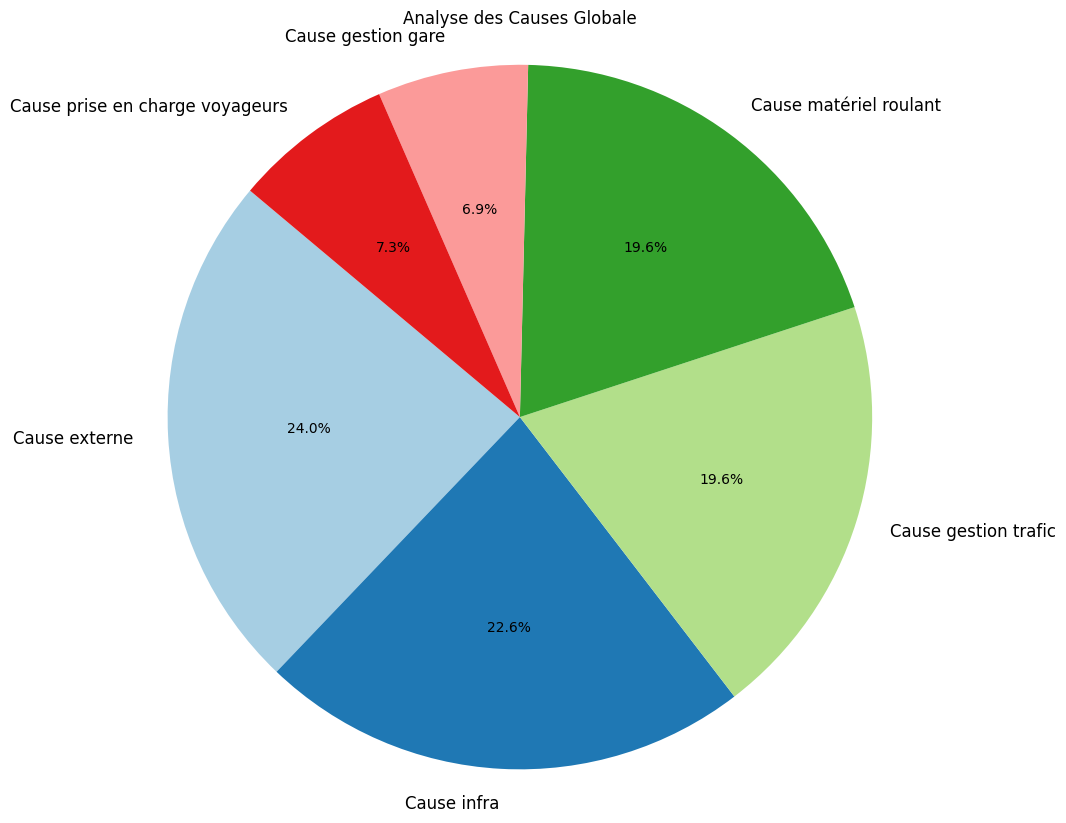

In [198]:
# Données pour le pie chart
causes = ["Cause externe", "Cause infra", "Cause gestion trafic", "Cause matériel roulant", "Cause gestion gare", "Cause prise en charge voyageurs"]
prct_causes = df_base[["prct_cause_externe", "prct_cause_infra", "prct_cause_gestion_trafic", "prct_cause_materiel_roulant", "prct_cause_gestion_gare", "prct_cause_prise_en_charge_voyageurs"]].mean()

# Créer un pie chart
plt.figure(figsize=(10, 10))
plt.pie(prct_causes, labels=causes, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(causes))))

# Titre
plt.title("Analyse des Causes Globale")
plt.axis('equal') 
plt.show()

Afin d'évaluer nos prochains modèles de machine learning une possibilité est de calculer la `RMSE` que nous obtenons si l'on préduit la moyenne à chaque instance (i.e les valeurs ci dessus). Ainsi si nous obtenons des algorithmes avec une `RMSE` supérieur il est inutiles de les conserverser.<br>

In [199]:
from sklearn.metrics import mean_squared_error

prct_causes = df_base[["prct_cause_externe", "prct_cause_infra", "prct_cause_gestion_trafic", "prct_cause_materiel_roulant", "prct_cause_gestion_gare", "prct_cause_prise_en_charge_voyageurs"]].mean()
# Nous créons un DataFrame de prédictions en utilisant la moyenne, en répétant la même moyenne pour chaque ligne
predictions = pd.DataFrame(np.tile(prct_causes.values, (len(df_base), 1)), columns=prct_causes.index)
# Nous prennons ensuite nous valeurs réelles
valeurs_reelles = df_base[["prct_cause_externe", "prct_cause_infra", "prct_cause_gestion_trafic", "prct_cause_materiel_roulant", "prct_cause_gestion_gare", "prct_cause_prise_en_charge_voyageurs"]]

# Calcul de RMSE
rmse = np.sqrt(mean_squared_error(valeurs_reelles, predictions, multioutput='raw_values'))
average_rmse = np.mean(rmse)
print(f"RMSE par colonne: {rmse}")
print(f"RMSE moyenne: {average_rmse}")

RMSE par colonne: [16.80416144 15.69155897 14.94663099 14.25565924  8.08026358 10.24882433]
RMSE moyenne: 13.33784975896364


<div class="alert alert-block alert-success">
<center>Après executions nous obtenons donc qu'il est nécessaire de battre une <strong>RMSE moyenne sur les 6 colonnes de 13.3</strong></center>
</div>


## 1.2 Importance de ligne grande vitesse

On peut donc maintenant ce poser la question de l'importance et de l'utilité de certain paramètres, <i>par example la ligne de train en question.</i>. <br>
Est ce qu'il existe de grand différence (dans les causes de retard) entre un Paris - Lyon et Bordeaux - Paris ? <br>
Pour cela on peut observer simplement la répartitions des causes pour différente lignes grande vitesse. C'est le plot que nous faisons ci-dessous. On observe alors que les répartitions peuvent varier fortement d'une ligne à l'autre, voici les intervalles de valeurs : 

+ Retards dus <strong>Externes</strong> : [13.32 - 46.44]
+ Retards liés aux <strong>infrastructures</strong> : [5.83 - 32.94]
+ Retards liés à la <strong>gestion du traffic</strong> : [8.18 - 38.49]
+ Retards liés au <strong>matériel roulant et son état</strong> : [2.02 - 40.96]
+ Retards liés à la <strong>gestion de gare</strong> : [0.00 - 13.97]
+ Retards liées à la <strong>prise en charge de voyageurs</strong> : [0.00 - 16.48]


<div class="alert alert-block alert-success">
<center><strong>Trouver une solution pour fournir comme input la ligne de train pour chaque instance pour être utile (cf plus tard)</strong></center>
</div>


In [200]:
## Analyse par ligne et par cause
df_base['ligne'] = df_base['gare_depart']+ ' - ' + df_base['gare_arrivee']
df_base_groupby_ligne = df_base.groupby("ligne").agg(
    Cause_externe = ("prct_cause_externe",'mean'),
    Cause_infra = ("prct_cause_infra",'mean'),
    Cause_gestion_trafic = ("prct_cause_gestion_trafic",'mean'),
    Cause_materiel_roulant = ("prct_cause_materiel_roulant",'mean'),
    Cause_gestion_gare = ("prct_cause_gestion_gare",'mean'),
    Cause_prise_en_charge_voyageurs = ("prct_cause_prise_en_charge_voyageurs",'mean')
)

df_base_groupby_ligne.describe()

,Cause_externe,Cause_infra,Cause_gestion_trafic,Cause_materiel_roulant,Cause_gestion_gare,Cause_prise_en_charge_voyageurs
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,23.167833,21.826077,19.312206,19.042383,6.512427,6.812622
std,5.758496,5.173468,6.752219,6.740557,2.907976,3.564499
min,13.315154,5.833333,8.184132,2.018519,0.000000,0.000000
25%,18.763478,17.977326,14.842170,14.424370,4.636959,4.377600
50%,22.511939,21.920464,18.175117,17.806214,6.027762,6.887764
75%,25.950208,25.098229,22.808956,22.952141,8.571360,9.198764
max,46.441287,32.940087,38.485028,40.957977,13.970732,16.479403


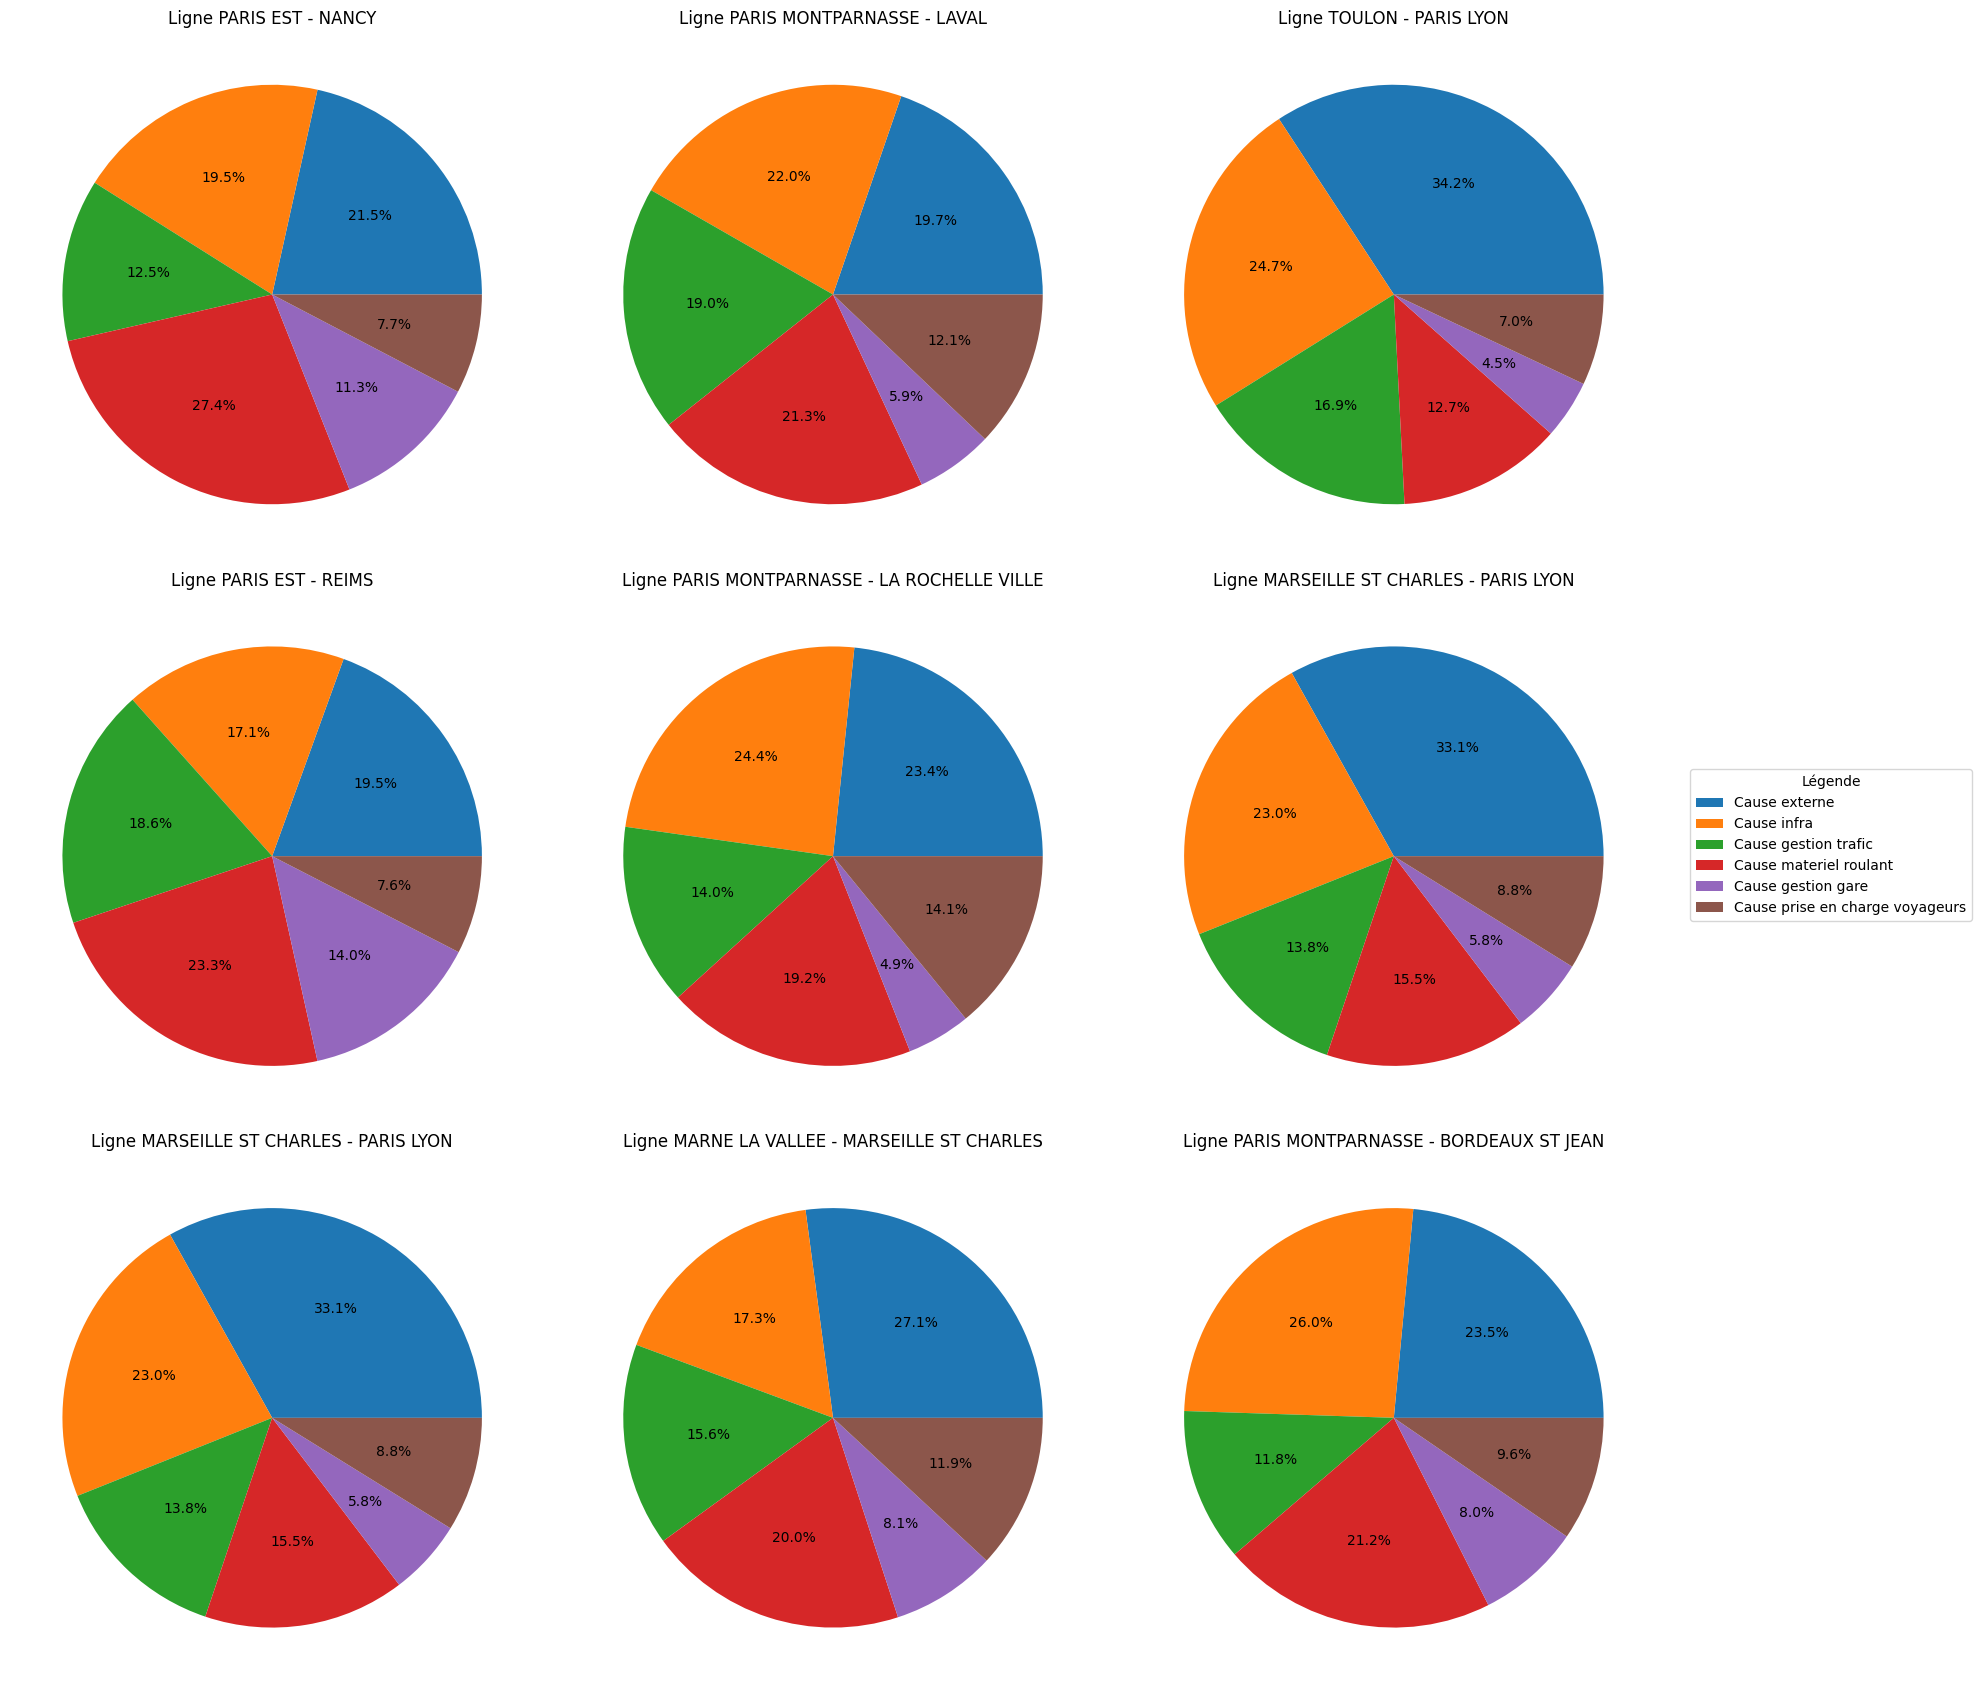

In [201]:
# Créez une liste pour stocker les 9 lignes sélectionnées
selected_lines = []

# Sélectionnez 9 lignes aléatoirement
for _ in range(9):
    selected_line = df_base_groupby_ligne.sample(1)
    selected_line = selected_line.reset_index()
    selected_lines.append(selected_line)

# Créez une grille de sous-graphiques de 3 lignes par 3 colonnes
fig, axes = plt.subplots(3, 3, figsize=(17, 17))


# Créez des graphiques pie pour chaque ligne sélectionnée
for i, selected_line in enumerate(selected_lines):
    # Réorganisez les données pour les rendre adaptées à un pie chart
    ligne_name = selected_line.ligne.values[0]
    selected_line = selected_line.drop(columns=['ligne']).T
    selected_line.columns = ['Pourcentage']

    # Créez un graphe pie
    ax = axes[i // 3, i % 3]
    wedges, texts, autotexts = ax.pie(selected_line['Pourcentage'], labels=[''] * len(selected_line.index), autopct='%1.1f%%')
    ax.set_title(f"Ligne {ligne_name}")

# Ajustez l'espacement entre les graphiques
plt.tight_layout()

# Créez une légende commune en dehors de la grille
legend_labels = ['Cause externe', 'Cause infra', 'Cause gestion trafic', 'Cause materiel roulant', 'Cause gestion gare', 'Cause prise en charge voyageurs']
fig.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5), title="Légende")


# Affichez les graphiques
plt.show()

## 1.3 Analyse temporelle

De même pour la paramètre temporelle on peut se demander s'il est important de l'intégrer dans notre analyse on observant son impact sur le résultat. On observe alors sur la courbe si dessous une variation de tendance avec des augmentation au mois de Décembre ainsi que pendant l'été. De même on peut donc conclure que : 

<div class="alert alert-block alert-success">
<center><strong>Trouver une solution pour fournir comme input la mois et l'année pour chaque instance pour être utile (cf plus tard)</strong></center>
</div>


In [202]:

df_month_group_by_month = df_base.groupby("date")[["prct_cause_externe", "prct_cause_infra", "prct_cause_gestion_trafic", "prct_cause_materiel_roulant", "prct_cause_gestion_gare", "prct_cause_prise_en_charge_voyageurs"]].mean().reset_index()
df_month_group_by_month.describe()

,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,23.256408,21.873734,19.027139,18.975042,6.738142,7.202008
std,6.633782,5.130633,5.030870,3.841347,1.968933,5.299615
min,2.985771,12.569776,2.439024,1.575638,1.715221,0.945549
25%,18.764834,17.628172,15.352034,17.386811,5.368219,2.824527
50%,22.316823,21.666973,20.137024,18.916528,6.770864,4.571791
75%,26.434798,24.599010,22.898227,21.288094,7.852787,10.232475
max,43.997518,36.247585,26.406690,28.034851,11.688541,21.313555


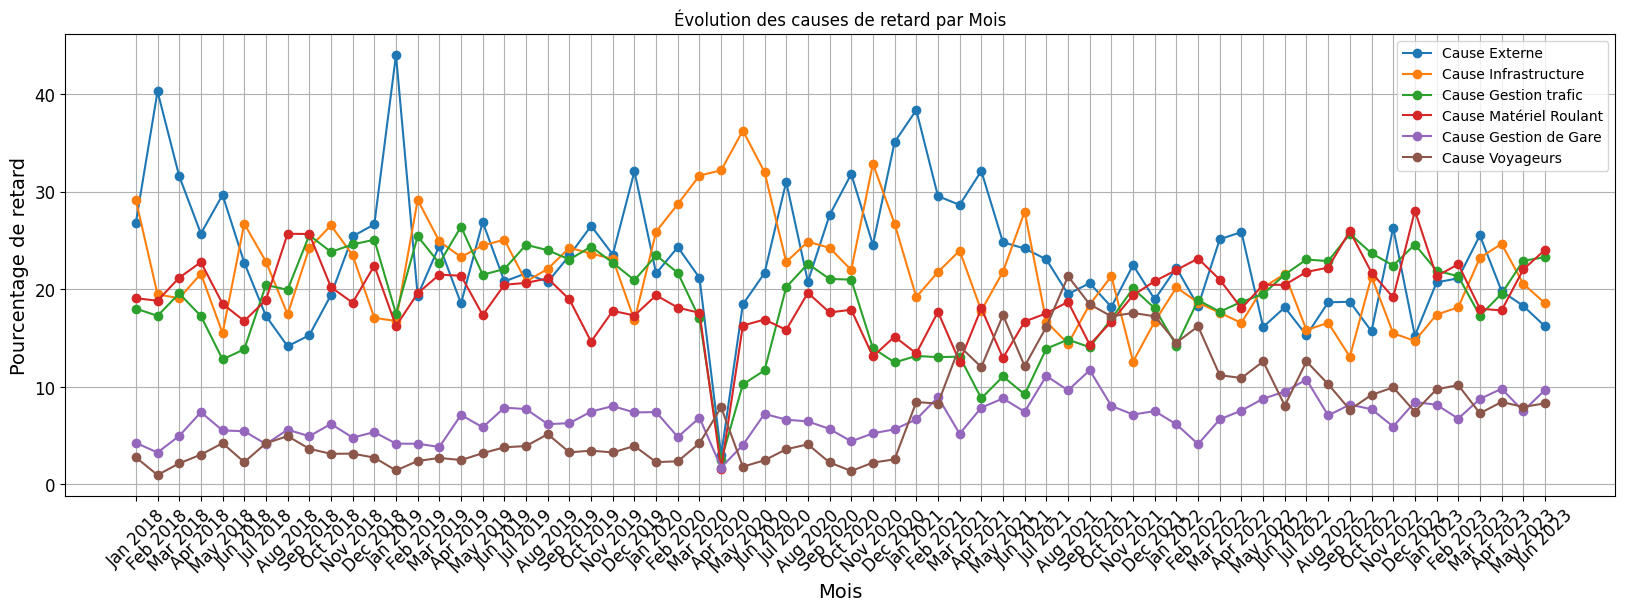

In [203]:
df_month_group_by_month['date'] = pd.to_datetime(df_month_group_by_month['date'])
df_month_group_by_month['date'] = df_month_group_by_month['date'].dt.to_period('M')
df_month_group_by_month = df_month_group_by_month.set_index("date")
df_month_group_by_month.index = df_month_group_by_month.index.strftime('%b %Y')

plt.figure(figsize=(20, 6))
plt.plot(df_month_group_by_month.index, df_month_group_by_month["prct_cause_externe"], marker='o', label='Cause Externe')
plt.plot(df_month_group_by_month.index, df_month_group_by_month["prct_cause_infra"], marker='o', label='Cause Infrastructure')
plt.plot(df_month_group_by_month.index, df_month_group_by_month["prct_cause_gestion_trafic"], marker='o', label='Cause Gestion trafic')
plt.plot(df_month_group_by_month.index, df_month_group_by_month["prct_cause_materiel_roulant"], marker='o', label='Cause Matériel Roulant')
plt.plot(df_month_group_by_month.index, df_month_group_by_month["prct_cause_gestion_gare"], marker='o', label='Cause Gestion de Gare')
plt.plot(df_month_group_by_month.index, df_month_group_by_month["prct_cause_prise_en_charge_voyageurs"], marker='o', label='Cause Voyageurs')
plt.title("Évolution des causes de retard par Mois")
plt.xlabel("Mois")
plt.ylabel("Pourcentage de retard")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

<center><strong>Analyse de l'évolution pour une ligne de train spécifique <i>PARIS LYON - LYON PART DIEU</i></strong></center>

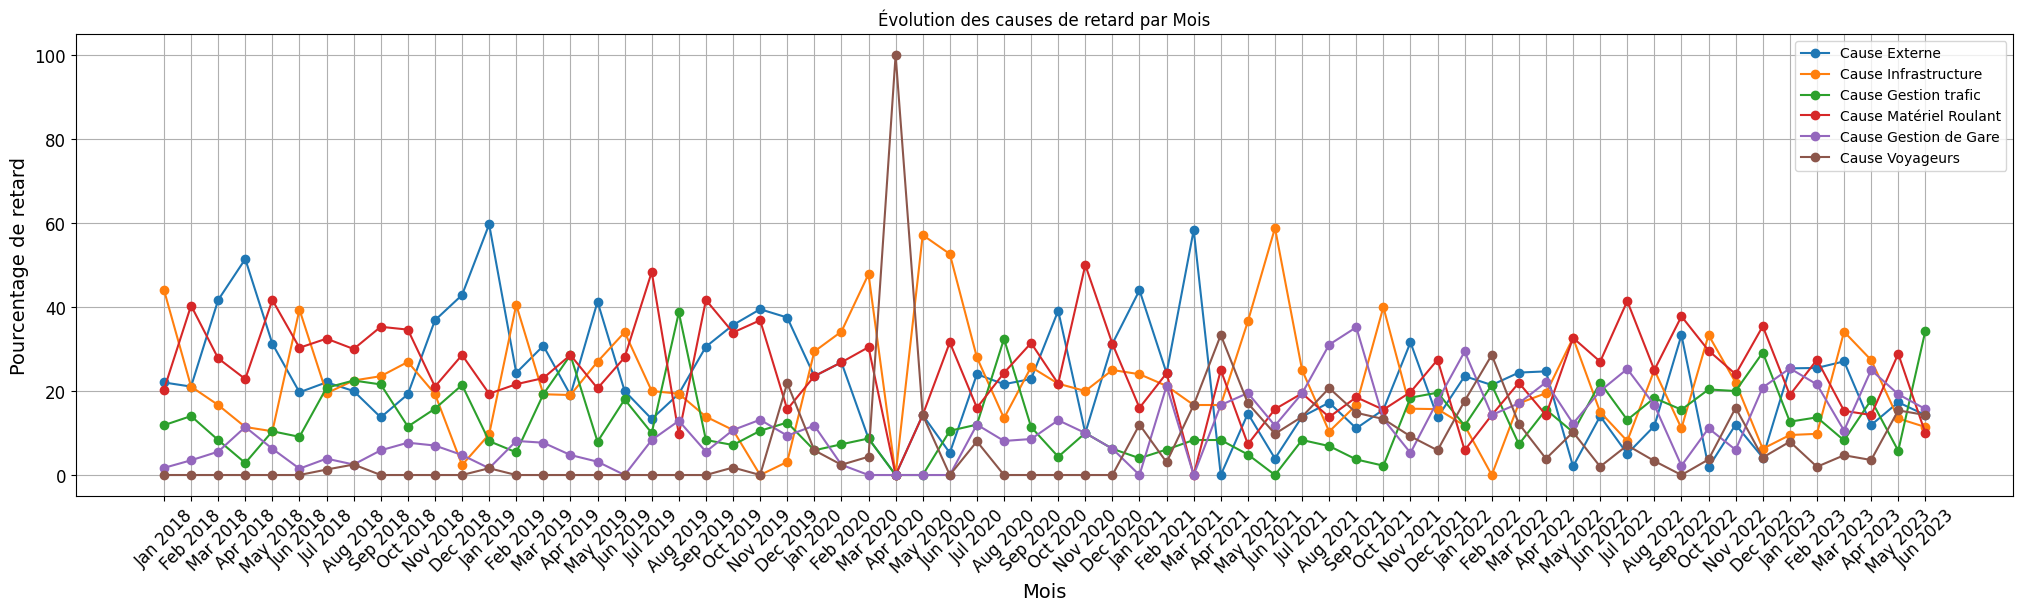

In [204]:
df_month_group_by_month_example = df_base[df_base.ligne == "PARIS LYON - LYON PART DIEU"].groupby("date")[["prct_cause_externe", "prct_cause_infra", "prct_cause_gestion_trafic", "prct_cause_materiel_roulant", "prct_cause_gestion_gare", "prct_cause_prise_en_charge_voyageurs"]].mean().reset_index()
df_month_group_by_month_example['date'] = pd.to_datetime(df_month_group_by_month_example['date'])
df_month_group_by_month_example['date'] = df_month_group_by_month_example['date'].dt.to_period('M')
df_month_group_by_month_example = df_month_group_by_month_example.set_index("date")
df_month_group_by_month_example.index = df_month_group_by_month_example.index.strftime('%b %Y')

plt.figure(figsize=(25, 6))
plt.plot(df_month_group_by_month_example.index, df_month_group_by_month_example["prct_cause_externe"], marker='o', label='Cause Externe')
plt.plot(df_month_group_by_month_example.index, df_month_group_by_month_example["prct_cause_infra"], marker='o', label='Cause Infrastructure')
plt.plot(df_month_group_by_month_example.index, df_month_group_by_month_example["prct_cause_gestion_trafic"], marker='o', label='Cause Gestion trafic')
plt.plot(df_month_group_by_month_example.index, df_month_group_by_month_example["prct_cause_materiel_roulant"], marker='o', label='Cause Matériel Roulant')
plt.plot(df_month_group_by_month_example.index, df_month_group_by_month_example["prct_cause_gestion_gare"], marker='o', label='Cause Gestion de Gare')
plt.plot(df_month_group_by_month_example.index, df_month_group_by_month_example["prct_cause_prise_en_charge_voyageurs"], marker='o', label='Cause Voyageurs')
plt.title("Évolution des causes de retard par Mois")
plt.xlabel("Mois")
plt.ylabel("Pourcentage de retard")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

## 1.4 Analyse de corrélations 

Ici notre but est de prédire la distrubitions des causes grâces à certaines features prédites précédemment, il est donc important de faire une analyse de corrélation entre ces features afin d'assurer les bonnes performances du modèle. 

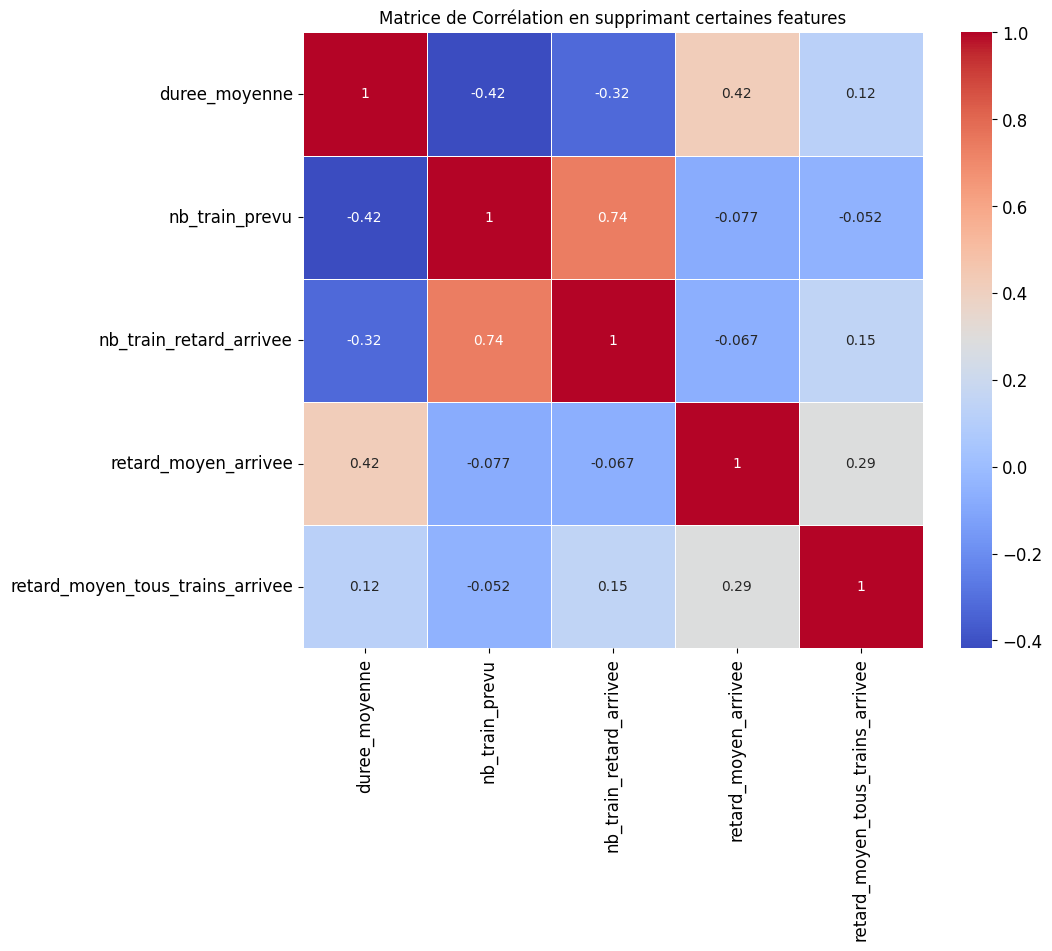

In [205]:
correlation_matrix = df_base[["duree_moyenne", "nb_train_prevu", "nb_train_retard_arrivee", "retard_moyen_arrivee", "retard_moyen_tous_trains_arrivee"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de Corrélation en supprimant certaines features")
plt.show()

On observe alors plusieurs fortes corrélations : 
+ Entre le <strong>nombre de train prévu</strong> et le <strong>nombre de train en retard</strong> : 074
+ Entre le <strong> retard moyen à l'arrivée</strong> et la <strong>durée moyenne du trajet</strong> : 0.42

<div class="alert alert-block alert-success">
<center>Nous allons donc utiliser deux nouvelles features composée <strong>la proportion de train en retard à l'arrivée</strong> ainsi que <strong>l'allongement du trajet</strong>.</center>
</div><br>

In [206]:
df_base["prop_train_retard_arrivee"] = df_base["nb_train_retard_arrivee"] / df_base["nb_train_prevu"] 
df_base["allongement_trajet"] = df_base["retard_moyen_arrivee"] / df_base["duree_moyenne"] 

# 2. Machine Learning Algorithms 

Il est maintenant temps de tester des algorithms de machine learning afin de prédire notre résultat pour faire cela nous allons principalement utiliser des `Regressor`.

## 2.1 Data Processing (Only Numerical)

In [207]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

# Define your pipelines
num_pipeline = Pipeline([
    ('std_scaler', MinMaxScaler())
])

numerical_features = ["prop_train_retard_arrivee","allongement_trajet","retard_moyen_tous_trains_arrivee"]

# Create a ColumnTransformer
sncf_data_transformer_1 = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
])
df_base[['prct_cause_externe_scaled','prct_cause_infra_scaled','prct_cause_gestion_trafic_scaled','prct_cause_materiel_roulant_scaled','prct_cause_gestion_gare_scaled','prct_cause_prise_en_charge_voyageurs_scaled']] = df_base[['prct_cause_externe','prct_cause_infra','prct_cause_gestion_trafic','prct_cause_materiel_roulant','prct_cause_gestion_gare','prct_cause_prise_en_charge_voyageurs']].apply(lambda x: x / x.sum(), axis=1)

Nous avons déclaré notre scaleur pour les entrées (X) et scaler nous outputs (y) entre 0 et 1.<br> Regardons si on a des valeurs NaN dans le dataset. On observe alors ci dessous que les commentaires sont manquants (pas un problème car nous n'allons pas faire `Language Processing` ici), mais que après avoir scalé les outputs 241 valeurs NaN apparaissent. <br>
Le premier cas de figure est dû aux instance avec aucun train en retards -> <strong> Nous allons donc supprimer en amont ces instances.</strong> <br>
Le deuxième cas de figure est dû au fait que pour <strong>159 instances</strong> les répartitions des causes ne sont pas fourni par la <i>data provider</i>. 
+ En regardant ces instances on peut voir que pour la plupart des lignes de TGV ces oublis représente une minorité des lignes du dataframe. Nous allons supprimer ces instances manquantes car nous ne pouvons pas les imputer car ce sont les données cible. 

In [208]:
df_base[['prct_cause_externe_scaled','prct_cause_infra_scaled','prct_cause_gestion_trafic_scaled','prct_cause_materiel_roulant_scaled','prct_cause_gestion_gare_scaled','prct_cause_prise_en_charge_voyageurs_scaled']].isna().sum()

prct_cause_externe_scaled                      241
prct_cause_infra_scaled                        241
prct_cause_gestion_trafic_scaled               241
prct_cause_materiel_roulant_scaled             241
prct_cause_gestion_gare_scaled                 241
prct_cause_prise_en_charge_voyageurs_scaled    241
dtype: int64

In [209]:
## Pourcentage de missing values pour chaque ligne
missing_values_df = 100*(df_base[df_base.prct_cause_gestion_trafic_scaled.isna()].ligne.value_counts())/df_base.ligne.value_counts()
missing_values_df.dropna(inplace=True)
missing_values_df.sort_values(ascending=False).head(10)

ligne
MARSEILLE ST CHARLES - MADRID       57.777778
PARIS LYON - BARCELONA              37.878788
TOURCOING - MARSEILLE ST CHARLES    30.769231
MADRID - MARSEILLE ST CHARLES       28.888889
TOURCOING - BORDEAUX ST JEAN        17.187500
RENNES - PARIS VAUGIRARD            16.666667
PARIS EST - STUTTGART               16.666667
BORDEAUX ST JEAN - TOURCOING        14.062500
STUTTGART - PARIS EST               12.121212
PARIS LYON - LAUSANNE               10.606061
Name: count, dtype: float64

In [210]:
## Premier traitement évident
df_base_cleaned = df_base.dropna(subset=['prct_cause_externe_scaled','prct_cause_infra_scaled','prct_cause_gestion_trafic_scaled','prct_cause_materiel_roulant_scaled','prct_cause_gestion_gare_scaled','prct_cause_prise_en_charge_voyageurs_scaled'])
df_base_cleaned[['prct_cause_externe_scaled','prct_cause_infra_scaled','prct_cause_gestion_trafic_scaled','prct_cause_materiel_roulant_scaled','prct_cause_gestion_gare_scaled','prct_cause_prise_en_charge_voyageurs_scaled']].isna().sum()

prct_cause_externe_scaled                      0
prct_cause_infra_scaled                        0
prct_cause_gestion_trafic_scaled               0
prct_cause_materiel_roulant_scaled             0
prct_cause_gestion_gare_scaled                 0
prct_cause_prise_en_charge_voyageurs_scaled    0
dtype: int64

## 2.2 Regression

Dans un premier temps nous allons simplement prédire en utilisant un programme de `LinearRegression` afin de prédire directement les 6 répartitions de causes pour chaque instance. <br>
<div class="alert alert-block alert-success">
<center><strong>On obtient alors un RMSE de 13,2</strong></center>
</div><br>

In [211]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

y = df_base_cleaned[['prct_cause_externe_scaled','prct_cause_infra_scaled','prct_cause_gestion_trafic_scaled','prct_cause_materiel_roulant_scaled','prct_cause_gestion_gare_scaled','prct_cause_prise_en_charge_voyageurs_scaled']]
X_train, X_test, y_train, y_test = train_test_split(df_base_cleaned, y, test_size=0.2, random_state=42)

X_train_scaled = sncf_data_transformer_1.fit_transform(X_train)
X_test_scaled = sncf_data_transformer_1.transform(X_test)

regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)
y_pred = regressor.predict(X_test_scaled)

# Calcul de RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
average_rmse = np.mean(rmse)
print(f"RMSE par colonne: {rmse}")
print(f"RMSE moyenne: {average_rmse}")

RMSE par colonne: [0.17036511 0.1515197  0.14615374 0.14405096 0.08071142 0.09792584]
RMSE moyenne: 0.13178779744974126


Le problème est que la somme de la répartition que l'on prédit ne fait pas nécessairement 1 lorsque l'on fait la somme des 6, il faut donc vérifier que c'est bien le cas et rescale les données si ce n'est pas le cas

In [212]:
## On vérifie que pour chaque instance les instances ne font pas plus 1
is_more_1 = (np.round(y_pred.sum(axis=1),5) > 1)
print(f"Nombre d'instances à rescale: {is_more_1.sum()}")

Nombre d'instances à rescale: 0


<center><div class="alert alert-block alert-warning">
<strong>Conclusion :</strong> Ce resultat n'est pas suffisant par rapport au score que nous devons battre. 
</div></center>

Un solution pour améliorer ce score pourrait d'ajouter les deux features dont on parlait au début. <br>
Pour cela nous allons <strong>Hasher texte</strong> qui correspond au ligne et séparer la date en mois et année qui sont des `int`.

In [214]:
from datetime import datetime
import hashlib

hash_values = []
def custom_hash(gare_depart, gare_arrivee):
    concatenated_data = f"{gare_depart} {gare_arrivee}"
    hasher = hashlib.sha256()
    hasher.update(concatenated_data.encode('utf-8'))
    hash_value = int(hasher.hexdigest(), 16)
    return hash_value

for index, row in df_base_cleaned.iterrows():
    gare_depart = row["gare_depart"]
    gare_arrivee = row["gare_arrivee"]
    
    hash_value = custom_hash(gare_depart, gare_arrivee)
    hash_values.append(hash_value)


date_data = df_base_cleaned["date"].to_list()
years = [int(datetime.strptime(date, "%Y-%m").year) for date in date_data]
months = [int(datetime.strptime(date, "%Y-%m").month) for date in date_data]

# Ajouter les nouvelles colonnes au DataFrame df_base_cleaned
df_base_cleaned["year"] = years
df_base_cleaned["month"] = months
df_base_cleaned["gare_hash"] = hash_values

/var/folders/2c/w923f0zj5w34cktd76cx92n40000gq/T/ipykernel_61842/1194761761.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base_cleaned["year"] = years
/var/folders/2c/w923f0zj5w34cktd76cx92n40000gq/T/ipykernel_61842/1194761761.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base_cleaned["month"] = months
/var/folders/2c/w923f0zj5w34cktd76cx92n40000gq/T/ipykernel_61842/1194761761.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

On peut donc écrire un nouvelle pipeline de transformation des données qui ne modifie pas les 3 nouvelles colonnes que nous avons créé mais qui les conserve

In [223]:
# Create a ColumnTransformer
numerical_features_2 = ["prop_train_retard_arrivee", "allongement_trajet", "retard_moyen_tous_trains_arrivee", "gare_hash"]
sncf_data_transformer_2 = ColumnTransformer([
    ("num", num_pipeline, numerical_features_2),
    ("year", 'passthrough', ["year"]), 
    ("month", 'passthrough', ["month"]),
])

On peut donc maintenant réentrainer nos modèle de régression desssus.

In [224]:
y = df_base_cleaned[['prct_cause_externe_scaled','prct_cause_infra_scaled','prct_cause_gestion_trafic_scaled','prct_cause_materiel_roulant_scaled','prct_cause_gestion_gare_scaled','prct_cause_prise_en_charge_voyageurs_scaled']]
X_train, X_test, y_train, y_test = train_test_split(df_base_cleaned, y, test_size=0.2, random_state=42)

X_train_scaled = sncf_data_transformer_2.fit_transform(X_train)
X_test_scaled = sncf_data_transformer_2.transform(X_test)

regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)
y_pred = regressor.predict(X_test_scaled)

# Calcul de RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
average_rmse = np.mean(rmse)
print(f"RMSE par colonne: {rmse}")
print(f"RMSE moyenne: {average_rmse}")

RMSE par colonne: [0.16864633 0.15044637 0.14577625 0.14399808 0.07981306 0.09259533]
RMSE moyenne: 0.13021256976139967


<div class="alert alert-block alert-success">
<center><strong>On obtient alors un RMSE de 13,0</strong></center>
</div><br>
Ce qui est mieux mais nous pouvons maintenant réflechir à d'autres algorithmes pour améliorer les perfomances

## 2.3 RandomForestRegressor

On utilise maintenant un regressor plus fort qui utilise du `Bagging` grâce à l'algorithme <strong>RandomForestRegressor</strong>. On utilise directement toutes les nouvelles données (<i>ligne et date</i>).
<div class="alert alert-block alert-success">
<center><strong>On obtient alors un RMSE de 12,4</strong></center>
</div><br>

In [225]:
from sklearn.ensemble import RandomForestRegressor

y = df_base_cleaned[['prct_cause_externe_scaled','prct_cause_infra_scaled','prct_cause_gestion_trafic_scaled','prct_cause_materiel_roulant_scaled','prct_cause_gestion_gare_scaled','prct_cause_prise_en_charge_voyageurs_scaled']]
X_train, X_test, y_train, y_test = train_test_split(df_base_cleaned, y, test_size=0.2, random_state=42)

X_train_scaled = sncf_data_transformer_2.fit_transform(X_train)
X_test_scaled = sncf_data_transformer_2.transform(X_test)

regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_scaled, y_train)
y_pred = regressor.predict(X_test_scaled)

# Calcul de RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
average_rmse = np.mean(rmse)
print(f"RMSE par colonne: {rmse}")
print(f"RMSE moyenne: {average_rmse}")

RMSE par colonne: [0.15287608 0.14397847 0.13891896 0.14133634 0.08011852 0.085564  ]
RMSE moyenne: 0.12379872719239032


In [230]:
import xgboost as xgb

y = df_base_cleaned[['prct_cause_externe_scaled','prct_cause_infra_scaled','prct_cause_gestion_trafic_scaled','prct_cause_materiel_roulant_scaled','prct_cause_gestion_gare_scaled','prct_cause_prise_en_charge_voyageurs_scaled']]
X_train, X_test, y_train, y_test = train_test_split(df_base_cleaned, y, test_size=0.2, random_state=42)

X_train_scaled = sncf_data_transformer_2.fit_transform(X_train)
X_test_scaled = sncf_data_transformer_2.transform(X_test)

regressor = xgb.XGBRegressor() 
regressor.fit(X_train_scaled, y_train)
y_pred = regressor.predict(X_test_scaled)
# Calcul de RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
average_rmse = np.mean(rmse)
print(f"RMSE par colonne: {rmse}")
print(f"RMSE moyenne: {average_rmse}")

/Users/BOULLIERERWAN1/opt/anaconda3/envs/aicourse_py39/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/BOULLIERERWAN1/opt/anaconda3/envs/aicourse_py39/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/BOULLIERERWAN1/opt/anaconda3/envs/aicourse_py39/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/BOULLIERERWAN1/opt/anaconda3/envs/aicourse_py39/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical

-3.2026319682866973
RMSE par colonne: [0.15745108 0.14700856 0.13676461 0.13778709 0.08123882 0.0831343 ]
RMSE moyenne: 0.12389741175125873


/Users/BOULLIERERWAN1/opt/anaconda3/envs/aicourse_py39/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/BOULLIERERWAN1/opt/anaconda3/envs/aicourse_py39/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/BOULLIERERWAN1/opt/anaconda3/envs/aicourse_py39/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/BOULLIERERWAN1/opt/anaconda3/envs/aicourse_py39/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated 